In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
train_cnt_file = "train/Competition_train_cnt.txt"
train_lab_file = "train/Competition_train_lab.txt"

train_cnt = np.loadtxt(train_cnt_file)
Y_train = np.loadtxt(train_lab_file)

print("Raw shape of train_cnt:", train_cnt.shape)


Raw shape of train_cnt: (17792, 3000)


In [4]:
n_trials_train = 278
n_channels = 64
n_samples = 3000

X_train = train_cnt.reshape(n_trials_train, n_channels, n_samples)

print("X_train final shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train final shape: (278, 64, 3000)
Y_train shape: (278,)


In [5]:
test_file = "test.txt"
test_label_file = "data/test/test_label.txt"

test_cnt = np.loadtxt(test_file)
Y_test = np.loadtxt(test_label_file)

print("Raw shape of test_cnt:", test_cnt.shape)

Raw shape of test_cnt: (6400, 3000)


In [6]:
n_trials_test = 100
X_test = test_cnt.reshape(n_trials_test, n_channels, n_samples)

print("test final shape:", X_test.shape)

test final shape: (100, 64, 3000)


In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Train Set Shape:", X_train.shape, Y_train.shape)
print("Validation Set Shape:", X_val.shape, Y_val.shape)

Train Set Shape: (222, 64, 3000) (222,)
Validation Set Shape: (56, 64, 3000) (56,)


In [8]:
def bandpass_filter(data, lowcut=8, highcut=30, fs=1000, order=5):
    """
    Apply a bandpass filter to the input data.

    Parameters:
        data (ndarray): EEG/ECoG data of shape (trials, channels, samples)
        lowcut (float): Lower cutoff frequency (default: 8 Hz)
        highcut (float): Upper cutoff frequency (default: 30 Hz)
        fs (int): Sampling frequency (default: 1000 Hz)
        order (int): Order of the filter (default: 5)

    Returns:
        ndarray: Filtered data (same shape as input)
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    filtered_data = lfilter(b, a, data, axis=-1)
    return filtered_data


In [9]:
X_train_filt = bandpass_filter(X_train)
X_val_filt = bandpass_filter(X_val)
X_test_filt = bandpass_filter(X_test)

## Classic CSP

In [10]:
def compute_covariance(trial_data):
    """
    Compute the covariance matrix for a given trial.
    
    Parameters:
        trial_data (ndarray): Shape (channels, samples)
    
    Returns:
        ndarray: Covariance matrix (channels x channels)
    """
    return np.cov(trial_data)

def csp_fit(X, y, n_components=3):
    """
    Fit CSP spatial filters.

    Parameters:
        X (ndarray): Shape (trials, channels, samples)
        y (ndarray): Labels (-1 or 1), shape (trials,)
        n_components (int): Number of CSP components to retain per class

    Returns:
        ndarray: CSP spatial filters (channels, 2 * n_components)
    """

    X_class1 = X[y == -1]
    X_class2 = X[y == 1]

    cov_class1 = np.mean([compute_covariance(x) for x in X_class1], axis=0)
    cov_class2 = np.mean([compute_covariance(x) for x in X_class2], axis=0)

    from scipy.linalg import eigh
    w, v = eigh(cov_class1, cov_class2)

    idx = np.argsort(w)[::-1]
    v = v[:, idx]
    filters = np.hstack([v[:, :n_components], v[:, -n_components:]])
    
    return filters

def csp_transform(X, filters):
    """
    Apply CSP transformation to extract log-variance features.

    Parameters:
        X (ndarray): Shape (trials, channels, samples)
        filters (ndarray): CSP spatial filters (channels, 2*n_components)

    Returns:
        ndarray: CSP features (trials, 2*n_components)
    """
    n_trials, _, _ = X.shape
    n_filters = filters.shape[1]
    features = np.zeros((n_trials, n_filters))

    for i in range(n_trials):
        projected = filters.T @ X[i] 
        var = np.var(projected, axis=1)
        features[i, :] = np.log(var)

    return features


In [11]:
csp_filters = csp_fit(X_train_filt, Y_train, n_components=3)

X_train_csp = csp_transform(X_train_filt, csp_filters)
X_val_csp = csp_transform(X_val_filt, csp_filters)
X_test_csp = csp_transform(X_test_filt, csp_filters)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_csp, Y_train)

pred_val = clf.predict(X_val_csp)
acc_val = accuracy_score(Y_val, pred_val)
print(f"Validation Accuracy: {acc_val:.4f}")


Validation Accuracy: 0.8929


In [12]:
pred_noadapt = clf.predict(X_test_csp)

acc_noadapt = accuracy_score(Y_test, pred_noadapt)
print(f"No Adaptation Test Accuracy: {acc_noadapt:.4f}")

print("Confusion Matrix (No Adaptation):")
print(confusion_matrix(Y_test, pred_noadapt))


No Adaptation Test Accuracy: 0.7600
Confusion Matrix (No Adaptation):
[[50  0]
 [24 26]]


## CORAL

In [13]:
def coral_transform(X_train, X_test):
    """
    Apply CORAL adaptation to align train and test feature distributions.

    Parameters:
        X_train (ndarray): Training CSP features, shape (trials, features)
        X_test (ndarray): Test CSP features, shape (trials, features)

    Returns:
        X_test_aligned (ndarray): Adapted test CSP features
    """
    # Compute covariance matrices
    cov_train = np.cov(X_train.T)  # (features, features)
    cov_test = np.cov(X_test.T)    # (features, features)

    # Solve eigenvalue decomposition
    d_train, v_train = np.linalg.eigh(cov_train)
    d_test, v_test = np.linalg.eigh(cov_test)

    # Regularize (avoid zero division)
    d_train[d_train < 1e-5] = 1e-5
    d_test[d_test < 1e-5] = 1e-5

    # Compute whitening and re-coloring matrices
    w_train = v_train @ np.diag(1.0 / np.sqrt(d_train)) @ v_train.T
    w_test = v_test @ np.diag(np.sqrt(d_test)) @ v_test.T

    # Align test features with train distribution
    X_test_aligned = X_test @ w_test @ w_train
    return X_test_aligned


In [14]:
# Compute CSP features
X_train_csp = csp_transform(X_train_filt, csp_filters)
X_val_csp = csp_transform(X_val_filt, csp_filters)
X_test_csp = csp_transform(X_test_filt, csp_filters)

X_test_csp_adapted = coral_transform(X_train_csp, X_test_csp)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_csp, Y_train)

Y_pred_adapted = clf.predict(X_test_csp_adapted)

from sklearn.metrics import accuracy_score
acc_coral = accuracy_score(Y_test, Y_pred_adapted)
print(f"CORAL Adaptation Test Accuracy: {acc_coral:.4f}")


CORAL Adaptation Test Accuracy: 0.8500


## TACNN

In [60]:
# Define frequency bands (e.g., 4-8 Hz, 8-12 Hz, etc.)
frequency_bands = [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 36), (36, 40)]

# Apply bandpass filter for each frequency band
X_train_filt = np.array([bandpass_filter(X_train, low, high, fs=1000) for (low, high) in frequency_bands])
X_val_filt = np.array([bandpass_filter(X_val, low, high, fs=1000) for (low, high) in frequency_bands])
X_test_filt = np.array([bandpass_filter(X_test, low, high, fs=1000) for (low, high) in frequency_bands])

# Reshape to combine frequency bands
# New shape: (trials, channels, samples, frequency_bands)
X_train_filt = np.transpose(X_train_filt, (1, 2, 3, 0))
X_val_filt = np.transpose(X_val_filt, (1, 2, 3, 0))
X_test_filt = np.transpose(X_test_filt, (1, 2, 3, 0))


In [61]:
def compute_covariance(trial_data, epsilon=1e-6):
    """
    Compute the covariance matrix for a given trial while ensuring numerical stability.
    """
    if trial_data.ndim == 3:
        trial_data = trial_data[0]  # Ensure it's (channels, samples)
    
    if trial_data.shape[0] > trial_data.shape[1]:  
        trial_data = trial_data.T  # Ensure (channels, samples) format

    cov_matrix = np.cov(trial_data)

    # Regularization: Avoid singular matrices
    cov_matrix += epsilon * np.eye(cov_matrix.shape[0])

    return cov_matrix



In [62]:
def csp_transform(X, filters):
    X = np.mean(X, axis=-1)  # Reduce frequency band dimension
    n_trials, _, _ = X.shape
    n_filters = filters.shape[1]
    features = np.zeros((n_trials, n_filters))

    for i in range(n_trials):
        projected = filters.T @ X[i]
        var = np.var(projected, axis=1)
        features[i, :] = np.log(var)  # Log transform for normalization

    return features

In [63]:
from scipy.linalg import eigh
def csp_fit(X, y, n_components=6):
    """
    Compute CSP filters while handling missing classes.
    """
    if X.ndim == 4:  # Reduce frequency bands dimension by averaging
        X = np.mean(X, axis=-1)

    # Separate trials by class
    X_class1 = X[y == 0]  # Class 0 trials
    X_class2 = X[y == 1]  # Class 1 trials

    # Ensure that both classes have at least one trial
    if len(X_class1) == 0 or len(X_class2) == 0:
        raise ValueError("One of the classes is missing from the dataset!")

    # Compute mean covariance for each class
    cov_class1 = np.mean([compute_covariance(trial) for trial in X_class1], axis=0)
    cov_class2 = np.mean([compute_covariance(trial) for trial in X_class2], axis=0)

    # Check for NaN or Inf values
    if np.isnan(cov_class1).any() or np.isinf(cov_class1).any():
        raise ValueError("cov_class1 contains NaN or Inf values!")
    if np.isnan(cov_class2).any() or np.isinf(cov_class2).any():
        raise ValueError("cov_class2 contains NaN or Inf values!")

    # Solve the generalized eigenvalue problem
    w, v = eigh(cov_class1, cov_class2)

    # Sort eigenvalues in descending order
    idx = np.argsort(np.abs(w))[::-1]
    v = v[:, idx]

    # Select top n CSP components
    filters = np.hstack([v[:, :n_components], v[:, -n_components:]])

    return filters


In [64]:
X_train_csp = csp_transform(X_train_filt, csp_filters)
X_val_csp = csp_transform(X_val_filt, csp_filters)
X_test_csp = csp_transform(X_test_filt, csp_filters)

# Reshape CSP features for CNN input
X_train_csp = X_train_csp.reshape(X_train_csp.shape[0], X_train_csp.shape[1], 1, 1)
X_val_csp = X_val_csp.reshape(X_val_csp.shape[0], X_val_csp.shape[1], 1, 1)
X_test_csp = X_test_csp.reshape(X_test_csp.shape[0], X_test_csp.shape[1], 1, 1)

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, AveragePooling1D, Dropout, Flatten, Dense, Lambda

# Define the TA-CSPNN model with correct input shape
model = Sequential([
    # Temporal Convolution (1D instead of 2D)
    Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(X_train_csp.shape[1], 1)),
    BatchNormalization(),

    # Non-linearity (Squared Activation Function)
    Lambda(lambda x: tf.math.square(x)),  # Square activation function

    # Average Pooling (1D instead of 2D)
    AveragePooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten and Fully Connected Layer
    Flatten(name="feature_layer"),
    Dense(units=1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [92]:
# Train the model
model.fit(X_train_csp, Y_train, epochs=100, batch_size=16, validation_data=(X_val_csp, Y_val), callbacks=early_stopping)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_csp, Y_test)
print(f'Adaptation Test Accuracy: {test_accuracy:.4f}')

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5676 - loss: 0.7105 - val_accuracy: 0.4821 - val_loss: 0.8308
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5310 - loss: 0.8141 - val_accuracy: 0.4821 - val_loss: 0.8426
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.5621 - val_accuracy: 0.4643 - val_loss: 0.8603
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6551 - loss: 0.6187 - val_accuracy: 0.4643 - val_loss: 0.8820
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.8246 - val_accuracy: 0.4643 - val_loss: 0.9038
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7266 - loss: 0.5410 - val_accuracy: 0.4464 - val_loss: 0.9323
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4865 - loss: 2.8312
Adaptation Test Accuracy: 0.5000


## TACNN + CORAL

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, AveragePooling1D, Dropout, Flatten, Dense, Lambda, Input

# Define input shape based on CSP features
input_layer = Input(shape=(X_train_csp.shape[1], 1), name="input_layer")

# Temporal Convolution (1D)
x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', name="conv1")(input_layer)
x = BatchNormalization(name="batch_norm1")(x)

# Squaring Activation
x = Lambda(lambda x: tf.math.square(x), name="squaring")(x)

# Average Pooling (1D)
x = AveragePooling1D(pool_size=2, name="pooling")(x)
x = Dropout(0.3, name="dropout")(x)

# Feature extraction layer
feature_layer = Flatten(name="feature_layer")(x)

# Fully Connected Layer for classification
output_layer = Dense(units=1, activation='sigmoid', name="output_layer")(feature_layer)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 12, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 12, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squaring (Lambda)               │ (None, 12, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling (AveragePooling1D)      │ (None, 6, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Flatten)         │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 16 (64.00 B)

None


In [98]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_csp, Y_train, epochs=100, batch_size=16, validation_data=(X_val_csp, Y_val), callbacks=[early_stopping])


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5834 - loss: 1.1970 - val_accuracy: 0.4643 - val_loss: 0.7516
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6585 - loss: 0.8881 - val_accuracy: 0.5357 - val_loss: 0.7212
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7254 - loss: 0.7351 - val_accuracy: 0.5714 - val_loss: 0.7112
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6847 - loss: 0.7034 - val_accuracy: 0.5357 - val_loss: 0.7132
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6918 - loss: 0.6152 - val_accuracy: 0.5179 - val_loss: 0.7220
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 0.6244 - val_accuracy: 0.5357 - val_loss: 0.7335
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6709 - loss: 0.6500 - val_accuracy: 0.5000 - val_loss: 0.7475
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7369 - loss: 0.5388 - val_accuracy: 0.5000 - v

In [100]:
from tensorflow.keras.models import Model

# Define the feature extractor model (extract features from the "feature_layer")
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("feature_layer").output)

# Extract features for CORAL
X_train_features = feature_extractor.predict(X_train_csp)
X_test_features = feature_extractor.predict(X_test_csp)

print("X_train_features shape:", X_train_features.shape)
print("X_test_features shape:", X_test_features.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
X_train_features shape: (222, 48)
X_test_features shape: (100, 48)


In [101]:
# Apply CORAL
X_test_coral = coral_transform(X_train_features, X_test_features)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM on CORAL-aligned train features
svm = SVC(kernel="linear")
svm.fit(X_train_features, Y_train)

# Predict on CORAL-aligned test features
Y_pred = svm.predict(X_test_coral)

# Compute accuracy
coral_accuracy = accuracy_score(Y_test, Y_pred)
print(f"CORAL Adaptation Test Accuracy (SVM): {coral_accuracy:.4f}")


CORAL Adaptation Test Accuracy (SVM): 0.5000


In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

X_test_coral = coral_transform(X_train_features, X_test_features)
# Train LDA on CORAL-aligned features
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_features, Y_train)

# Predict on CORAL-aligned test features
Y_pred_lda = lda.predict(X_test_coral)

# Compute accuracy
coral_accuracy_lda = accuracy_score(Y_test, Y_pred_lda)
print(f"CORAL Adaptation Test Accuracy (LDA): {coral_accuracy_lda:.4f}")


CORAL Adaptation Test Accuracy (LDA): 0.4900


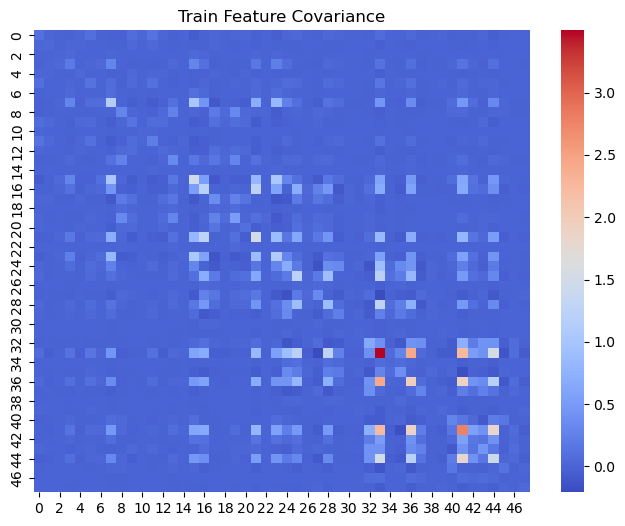

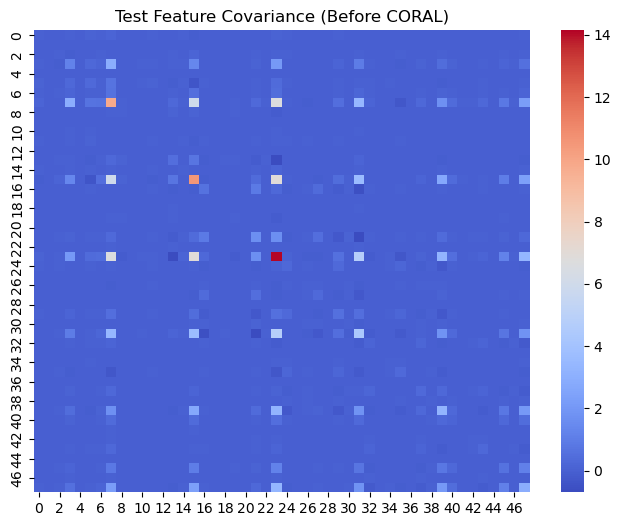

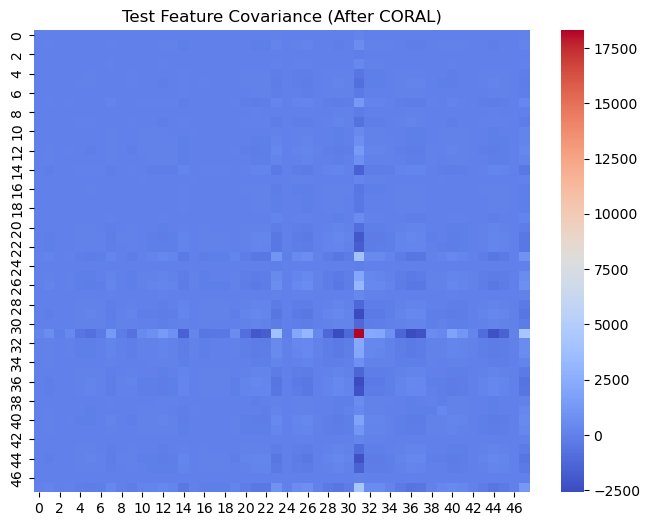

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cov_matrix(X, title):
    cov_matrix = np.cov(X.T)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cov_matrix, cmap='coolwarm')
    plt.title(title)
    plt.show()

# Plot before CORAL
plot_cov_matrix(X_train_features, "Train Feature Covariance")
plot_cov_matrix(X_test_features, "Test Feature Covariance (Before CORAL)")

# Apply CORAL
X_test_coral = coral_transform(X_train_features, X_test_features)

# Plot after CORAL
plot_cov_matrix(X_test_coral, "Test Feature Covariance (After CORAL)")


In [116]:
def coral_loss(source, target):
    """
    Compute CORrelation ALignment (CORAL) loss to minimize the difference 
    in covariance between source and target feature distributions.

    Parameters:
        source (tf.Tensor): Feature representations of source domain (batch_size, features)
        target (tf.Tensor): Feature representations of target domain (batch_size, features)

    Returns:
        tf.Tensor: Scalar loss value
    """
    d = tf.cast(tf.shape(source)[1], tf.float32)  # Feature dimensionality

    # Compute covariance matrices
    source_cov = tf.matmul(tf.transpose(source), source) / tf.cast(tf.shape(source)[0] - 1, tf.float32)
    target_cov = tf.matmul(tf.transpose(target), target) / tf.cast(tf.shape(target)[0] - 1, tf.float32)

    # Compute Frobenius norm of the covariance difference
    loss = tf.reduce_mean(tf.square(source_cov - target_cov)) / (4 * d * d)

    return loss


In [117]:
def build_deep_coral_model(input_shape):
    """
    Build the Deep CORAL model with shared feature extraction layers.
    
    Parameters:
        input_shape (tuple): Shape of the input data (time_steps, channels)

    Returns:
        model (tf.keras.Model): Deep CORAL Model
    """
    # Define input layer
    input_layer = Input(shape=input_shape, name="input_layer")

    # Temporal Convolution (1D)
    conv1 = Conv1D(filters=8, kernel_size=3, padding="same", activation="relu", name="conv1")(input_layer)
    bn1 = BatchNormalization(name="batch_norm1")(conv1)

    # Squaring Activation
    squared = Lambda(lambda x: tf.math.square(x), name="squaring")(bn1)

    # Average Pooling
    pooling = AveragePooling1D(pool_size=2, name="pooling")(squared)
    dropout = Dropout(0.3, name="dropout")(pooling)

    # Feature Extraction Layer
    feature_layer = Flatten(name="feature_layer")(dropout)

    # Classification Output Layer
    output_layer = Dense(units=1, activation="sigmoid", name="output_layer")(feature_layer)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="DeepCORAL_Model")

    return model


In [118]:
# Initialize Model
input_shape = (X_train_csp.shape[1], X_train_csp.shape[2])
model = build_deep_coral_model(input_shape)

# Extract Feature Representation Model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("feature_layer").output)

# Define Optimizer and Loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
classification_loss_fn = tf.keras.losses.BinaryCrossentropy()

# Custom Training Loop with CORAL Loss
epochs = 50
batch_size = 16

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass
        source_preds = model(X_train_csp, training=True)
        target_preds = model(X_test_csp, training=True)

        # Extract Feature Representations
        source_features = feature_extractor(X_train_csp, training=True)
        target_features = feature_extractor(X_test_csp, training=True)

        # Compute Losses
        loss_classification = classification_loss_fn(Y_train, source_preds)
        loss_coral = coral_loss(source_features, target_features)
        total_loss = loss_classification + 0.01 * loss_coral  # Weighting factor

    # Compute Gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Print Loss per Epoch
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss.numpy():.4f} - Class Loss: {loss_classification.numpy():.4f} - CORAL Loss: {loss_coral.numpy():.4f}")


Epoch 1/50 - Loss: 1.5054 - Class Loss: 1.5053 - CORAL Loss: 0.0079
Epoch 2/50 - Loss: 1.2419 - Class Loss: 1.2417 - CORAL Loss: 0.0176
Epoch 3/50 - Loss: 1.3120 - Class Loss: 1.3118 - CORAL Loss: 0.0186
Epoch 4/50 - Loss: 1.3349 - Class Loss: 1.3348 - CORAL Loss: 0.0097
Epoch 5/50 - Loss: 1.2821 - Class Loss: 1.2819 - CORAL Loss: 0.0177
Epoch 6/50 - Loss: 1.1975 - Class Loss: 1.1974 - CORAL Loss: 0.0072
Epoch 7/50 - Loss: 1.3801 - Class Loss: 1.3799 - CORAL Loss: 0.0117
Epoch 8/50 - Loss: 1.2525 - Class Loss: 1.2523 - CORAL Loss: 0.0128
Epoch 9/50 - Loss: 1.1015 - Class Loss: 1.1015 - CORAL Loss: 0.0042
Epoch 10/50 - Loss: 1.0832 - Class Loss: 1.0830 - CORAL Loss: 0.0174
Epoch 11/50 - Loss: 1.1957 - Class Loss: 1.1955 - CORAL Loss: 0.0165
Epoch 12/50 - Loss: 0.9894 - Class Loss: 0.9893 - CORAL Loss: 0.0092
Epoch 13/50 - Loss: 1.1785 - Class Loss: 1.1783 - CORAL Loss: 0.0140
Epoch 14/50 - Loss: 1.0086 - Class Loss: 1.0085 - CORAL Loss: 0.0090
Epoch 15/50 - Loss: 1.0132 - Class Loss: 1.

In [119]:
# Predict on Test Set
preds = model.predict(X_test_csp)
final_predictions = (preds > 0.5).astype(int)

# Compute Accuracy
accuracy = np.mean(final_predictions.flatten() == Y_test.flatten())
print(f"Deep CORAL Adaptation Test Accuracy: {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Deep CORAL Adaptation Test Accuracy: 0.4900


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


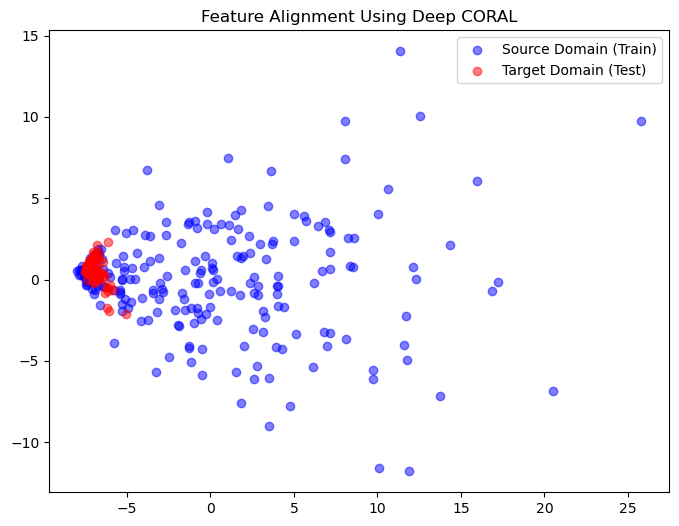

In [122]:
from sklearn.decomposition import PCA

# Extract features again after training
X_train_features = feature_extractor.predict(X_train_csp)
X_test_features = feature_extractor.predict(X_test_csp)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Plot Results
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c="blue", alpha=0.5, label="Source Domain (Train)")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c="red", alpha=0.5, label="Target Domain (Test)")
plt.legend()
plt.title("Feature Alignment Using Deep CORAL")
plt.show()


In [120]:
X_train_csp_reshaped = X_train_csp.reshape(X_train_csp.shape[0], -1)
X_test_csp_reshaped = X_test_csp.reshape(X_test_csp.shape[0], -1)

# Check shape after reshaping
print("Reshaped X_train_csp:", X_train_csp_reshaped.shape)
print("Reshaped X_test_csp:", X_test_csp_reshaped.shape)


Reshaped X_train_csp: (222, 12)
Reshaped X_test_csp: (100, 12)


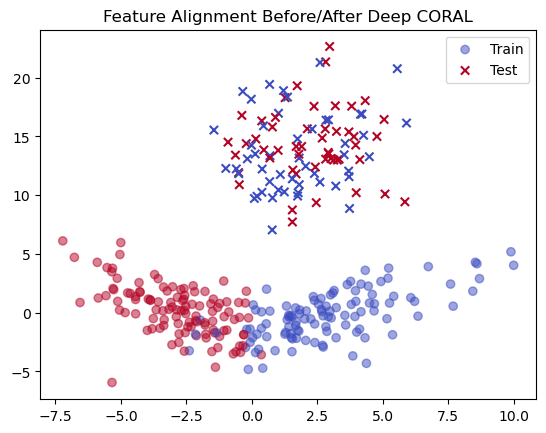

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_csp_reshaped)
X_test_pca = pca.transform(X_test_csp_reshaped)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, cmap="coolwarm", alpha=0.5, label="Train")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=Y_test, cmap="coolwarm", marker="x", label="Test")
plt.legend()
plt.title("Feature Alignment Before/After Deep CORAL")
plt.show()
